In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/MuraDataset')

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img
# from keras_preprocessing.image import ImageDataGenerator,load_img
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split

In [4]:
os.listdir("/content/drive/MyDrive/MuraDataset/MURA-v1.1")

['train_labeled_studies.csv',
 'valid_labeled_studies.csv',
 'train_image_paths.csv',
 'valid_image_paths.csv',
 'train_images_display_copy.csv',
 'train_images_display.csv',
 'valid',
 'train']

In [5]:
# Train set studies with labels
df=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/train_labeled_studies.csv', names=['Train_Image','Train_Label'])

In [6]:
df.head()

,Train_Image,Train_Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [7]:
# Adding labels to individual images in train set
df1=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/train_image_paths.csv', names=['Train_Image'])
df1 = df1[df1['Train_Image'].str.split('/').str[2]== 'XR_FINGER']
names=df1['Train_Image'].values


In [8]:
train_labels=[]

for i in names:
    if ('positive' in i):
        train_labels.append('1')
    elif('negative' in i):
        train_labels.append('0')

train_labels = np.array(train_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df1.insert(1, 'Train_Label', train_labels)

In [9]:
print(train_labels)

['1' '1' '1' ... '0' '0' '0']


In [10]:
df1.head()

,Train_Image,Train_Label
9651,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,1
9652,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,1
9653,MURA-v1.1/train/XR_FINGER/patient03227/study1_...,1
9654,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,1
9655,MURA-v1.1/train/XR_FINGER/patient03228/study1_...,1


In [11]:
df1.shape

(5106, 2)

In [12]:
df1['Train_Image'] = '/content/drive/MyDrive/MuraDataset/' + df1['Train_Image']

In [13]:
df1.to_csv('Train_set.csv', index=False)

In [14]:
#Validation set studies with labels
df_valid=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/valid_labeled_studies.csv', names=['Valid_Image','Valid_Label'])

In [15]:
df_valid.head()

,Valid_Image,Valid_Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [16]:
# Adding labels to individual images in validation set
df_valid1=pd.read_csv('/content/drive/MyDrive/MuraDataset/MURA-v1.1/valid_image_paths.csv', names=['Valid_Image'])
df_valid1 = df_valid1[df_valid1['Valid_Image'].str.split('/').str[2]== 'XR_FINGER']
names=df_valid1['Valid_Image'].values
valid_labels=[]

for i in names:
  if ('positive' in i):
    valid_labels.append('1')
  elif('negative' in i):
    valid_labels.append('0')

valid_labels = np.array(valid_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df_valid1.insert(1, 'Valid_Label', valid_labels)
df_valid1.to_csv('Valid_set.csv', index=False)

In [17]:
df_valid1.head()

,Valid_Image,Valid_Label
2736,MURA-v1.1/valid/XR_FINGER/patient11882/study1_...,1
2737,MURA-v1.1/valid/XR_FINGER/patient11882/study1_...,1
2738,MURA-v1.1/valid/XR_FINGER/patient11883/study1_...,1
2739,MURA-v1.1/valid/XR_FINGER/patient11883/study1_...,1
2740,MURA-v1.1/valid/XR_FINGER/patient11883/study1_...,1


In [18]:
df_valid1.shape

(461, 2)

In [19]:
df_valid1['Valid_Image'] = '/content/drive/MyDrive/MuraDataset/' + df_valid1['Valid_Image']
df_valid1.to_csv('Valid_set.csv', index=False)

In [20]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set.csv", dtype=str)
# valid_df = pd.read_csv("./Valid_set.csv", dtype=str)

In [21]:
valid_df = pd.read_csv("./Valid_set.csv", dtype=str)

In [22]:
train_data, test_data = train_test_split(train_df, test_size=0.1,random_state=4,stratify = train_df['Train_Label'])

In [23]:
train_samples = pd.DataFrame(train_data)
test_samples = pd.DataFrame(test_data)

In [24]:
print(len(train_samples))
print(len(test_samples))

4595
511


In [25]:
# Import DenseNet169 pre-trained model
dense_model = DenseNet169(include_top=False, weights='imagenet',pooling = 'avg')

In [26]:
#Freeze the layers
dense_model.trainable = False

In [27]:
for layer in dense_model.layers[586:]:
    layer.trainable = True

    
for layer in dense_model.layers:
    print(layer,layer.trainable)     

<keras.engine.input_layer.InputLayer object at 0x7fd8476b34d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fd8443af8d0> False
<keras.layers.convolutional.Conv2D object at 0x7fd8443afb50> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fd844681550> False
<keras.layers.core.Activation object at 0x7fd844665390> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fd844626d90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd844663690> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fd8445fb090> False
<keras.layers.core.Activation object at 0x7fd8445fbf10> False
<keras.layers.convolutional.Conv2D object at 0x7fd844606450> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fd8446000d0> False
<keras.layers.core.Activation object at 0x7fd84460aa50> False
<keras.layers.convolutional.Conv2D object at 0x7fd844626850> False
<keras.layers.merge.Concatenate object at 0x7fd844663190> False
<keras.layers.norma

In [28]:
predictions = Dense(1, activation='sigmoid')(dense_model.layers[-1].output)
model = Model(inputs=dense_model.input, outputs=predictions)

In [29]:
filepath = '/content/drive/MyDrive/MuraDataset/'
model.load_weights(filepath+'bestmodel/fingermodel-00003-0.25046-0.73472-0.26254-0.73750.h5',by_name = True)

In [30]:
import cv2
def get_testdata():
    image_data = []
    x_data = []
    y_data = []
    for index, row in test_samples.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [31]:
testx1,testy1 = get_testdata()
print(testx1.shape)
print(testy1.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(511, 300, 300, 3)
(511,)


In [32]:
testy1 = list(map(int, testy1))

In [33]:
# predict probabilities for test set
y_probs = model.predict(testx1 , verbose=0)
# predict crisp classes for test set
y_classes = (y_probs > 0.5).astype('int32')


In [34]:
# reduce to 1d array
y_probs = y_probs[:, 0]
y_classes = y_classes[:, 0]

In [35]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [36]:
# accuracy: (tp + tn) / (p + n)
test_accuracy = accuracy_score(testy1, y_classes)
print('Accuracy: %f' % test_accuracy)
# precision tp / (tp + fp)
test_precision = precision_score(testy1, y_classes)
print('Precision: %f' % test_precision)
# recall: tp / (tp + fn)
test_recall = recall_score(testy1, y_classes)
print('Recall: %f' % test_recall)
# f1: 2 tp / (2 tp + fp + fn)
test_f1 = f1_score(testy1, y_classes)
print('F1 score: %f' % test_f1)
# kappa
test_kappa = cohen_kappa_score(testy1, y_classes)
print('Cohens kappa: %f' % test_kappa)
# ROC AUC
test_auc = roc_auc_score(testy1, y_probs)
print('ROC AUC: %f' % test_auc)
# confusion matrix
test_matrix = confusion_matrix(testy1, y_classes)
print(test_matrix)

Accuracy: 0.772994
Precision: 0.707692
Recall: 0.700508
F1 score: 0.704082
Cohens kappa: 0.519962
ROC AUC: 0.847813
[[257  57]
 [ 59 138]]


In [37]:
from sklearn.metrics import roc_curve
fpr_test, tpr_test, thresholds_test = roc_curve(testy1, y_probs)

In [38]:
from sklearn.metrics import auc
auc_test = auc(fpr_test, tpr_test)

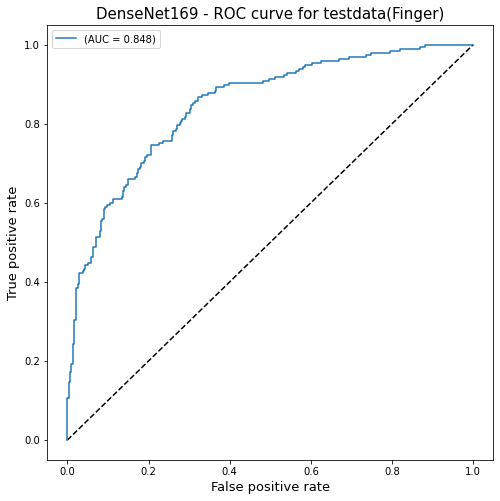

In [54]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='(AUC = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('DenseNet169 - ROC curve for testdata(Finger)',fontsize=15)
plt.legend(loc='best')
plt.savefig(filepath+'denseroctest_finger',dpi=300)
plt.show()

In [40]:
import cv2
def get_data():
    image_data = []
    x_data = []
    y_data = []
    for index, row in valid_df.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [41]:
testX,testY = get_data()
testY = list(map(int, testY))


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [42]:
# predict probabilities for test set
yhat_probs = model.predict(testX , verbose=0)
# predict crisp classes for test set
yhat_classes = (yhat_probs > 0.5).astype('int32')


In [43]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [44]:
print(yhat_probs)

[0.25203133 0.36431766 0.70868254 0.7642365  0.6535245  0.37744266
 0.41188365 0.3161217  0.34588116 0.27087045 0.37328565 0.09264618
 0.61498445 0.69053215 0.7430766  0.6963861  0.75814915 0.63771003
 0.6814096  0.51010805 0.7299113  0.7661456  0.935157   0.9264704
 0.80683935 0.9150049  0.95449066 0.6351727  0.7118981  0.65237963
 0.40525147 0.5114715  0.75097525 0.6574896  0.8766793  0.07415697
 0.05943218 0.07118005 0.68269026 0.8213929  0.7576602  0.7079131
 0.67621505 0.81234145 0.9314205  0.80942345 0.8580625  0.93783027
 0.70698583 0.83754957 0.08333746 0.440879   0.59567827 0.44602022
 0.88353    0.9254607  0.9584389  0.3545568  0.27631897 0.6910638
 0.3909555  0.5567935  0.8408233  0.81740403 0.8392233  0.7805548
 0.91923964 0.8306793  0.710654   0.6785353  0.77671075 0.65940684
 0.4804501  0.5560312  0.7896236  0.5313585  0.3822995  0.6212401
 0.9225278  0.5075613  0.5466241  0.42102408 0.22383076 0.5025954
 0.82497156 0.939866   0.8985382  0.65454733 0.6251176  0.71085036
 

In [45]:
print(yhat_classes)

[0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1
 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1
 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [46]:
print(testY)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [47]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [48]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.752711
Precision: 0.800905
Recall: 0.716599
F1 score: 0.756410


In [49]:
# kappa
kappa = cohen_kappa_score(testY, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testY, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testY, yhat_classes)
print(matrix)

Cohens kappa: 0.506878
ROC AUC: 0.814598
[[170  44]
 [ 70 177]]


In [50]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, yhat_probs)

In [51]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

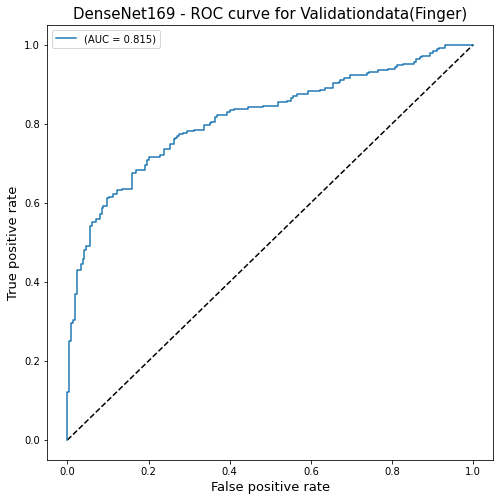

In [53]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('DenseNet169 - ROC curve for Validationdata(Finger)',fontsize=15)
plt.legend(loc='best')
plt.savefig(filepath+'denserocvalidation_finger',dpi=300)
plt.show()
